In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Data input and processing

In [67]:
def standard_error(series):
    return series.std() / np.sqrt(series.count())

def process_data(new_file_path, previous_df=None):
    """
    Processes the experiment data from a new CSV file. If a previous DataFrame is provided,
    appends the new data to it; otherwise, creates a new DataFrame.

    Parameters:
    previous_df (pandas.DataFrame, optional): The existing DataFrame to append to. Defaults to None.
    new_file_path (str): The file path to the new CSV file containing the experiment data.

    Returns:
    pandas.DataFrame: A DataFrame with the combined data.
    """
    # Load the data from the new CSV file
    new_data = pd.read_csv(new_file_path)

    # Add a new column for method_name based on the value of method
    new_data['method_name'] = new_data.apply(lambda x: x['prune_method'] if x['method'] == 'prune' else x['quant_method'] if x['method'] == 'quant' else None, axis=1)
    new_data['method_name'] = new_data['method_name'].replace({'autoawq': 'AWQ', 'autogptq': 'GPTQ', 'sparsegpt': 'SparseGPT', 'wanda': 'Wanda'})

    # Check if 'PPL edits' column exists
    if 'PPL edits' in new_data.columns:
        aggregation_columns = ['Rewrite accuracy', 'PPL', 'Generalization', 'Latency', 'Locality', 'PPL edits']
    else:
        aggregation_columns = ['Rewrite accuracy', 'PPL', 'Generalization', 'Latency', 'Locality']
        # new_data['PPL edits'] = np.nan  # Create an empty 'PPL edits' column


    # Group by 'Tags' and calculate mean and standard error for the selected columns
    grouped_new_data = new_data.groupby('Tags')[aggregation_columns].agg(['mean', standard_error])

    # Flatten multi-level columns and rename them
    grouped_new_data.columns = ['_'.join(col).strip() for col in grouped_new_data.columns.values]

    # Merge the grouped new data with the extracted information
    final_new_df = pd.merge(grouped_new_data.reset_index(), new_data[['Tags', 'alg_name', 'edit', 'compress', 'sparsity_ratio', 'method_name', 'Average bits']], 
                            on='Tags', how='left').drop_duplicates()

    # Reordering columns
    final_cols = ['alg_name', 'edit', 'compress', 'sparsity_ratio', 'method_name'] + \
                 [col for col in final_new_df.columns if col not in ['alg_name', 'edit', 'compress', 'sparsity_ratio', 'Tags', 'method_name']]
    final_new_df = final_new_df[final_cols]

    # If a previous DataFrame is provided, append the new data; otherwise, use the new data as the DataFrame
    if previous_df is not None:
        combined_df = pd.concat([previous_df, final_new_df], ignore_index=True)
    else:
        combined_df = final_new_df

    return combined_df

In [68]:
## Counterfact

# No edits
unedited_counterfact = process_data('data/counterfact/none.csv')
unedited_counterfact = process_data('data/counterfact/noedit_compress.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/noedit_compress_extra.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W4_GPTQ.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W8_GPTQ.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W4_AWQ.csv', unedited_counterfact)

# With MEMIT
edited_counterfact = process_data('data/counterfact/memit.csv')
edited_counterfact = process_data('data/counterfact/edit_compress.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/edit_compress_extra.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W4_Edits_GPTQ.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W8_Edits_GPTQ.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W4_Edits_AWQ.csv', edited_counterfact)

# Compress First
compfirst_counterfact = process_data('data/counterfact/memit.csv')
compfirst_counterfact = process_data('data/counterfact/compress_first.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W3_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W4_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W8_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)

## ZSRE

# No edits
unedited_zsre = process_data('data/zsre/none.csv')
unedited_zsre = process_data('data/zsre/noedit_compress.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/noedit_compress_extra.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/ZSRE_W4_GPTQ.csv', unedited_zsre)  # Updated file name
unedited_zsre = process_data('data/zsre/ZSRE_W8_GPTQ.csv', unedited_zsre)  # Updated file name
unedited_zsre = process_data('data/zsre/ZSRE_W4_AWQ.csv', unedited_zsre)  # Updated file name

# With MEMIT
edited_zsre = process_data('data/zsre/memit.csv')
edited_zsre = process_data('data/zsre/edit_compress.csv', edited_zsre)
edited_zsre = process_data('data/zsre/edit_compress_extra.csv', edited_zsre)
edited_zsre = process_data('data/zsre/ZSRE_W4_Edits_GPTQ.csv', edited_zsre)  # Updated file name
edited_zsre = process_data('data/zsre/ZSRE_W8_Edits_GPTQ.csv', edited_zsre)  # Updated file name
edited_zsre = process_data('data/zsre/ZSRE_W4_Edits_AWQ.csv', edited_zsre)  # Updated file name

# Compress first
compfirst_zsre = process_data('data/zsre/compress_first.csv')
compfirst_zsre = process_data('data/zsre/memit_only.csv', compfirst_zsre)
compfirst_zsre = process_data('data/zsre/ZSRE_W8_GPTQ_Edits_GPTQ.csv', compfirst_zsre)
compfirst_zsre = process_data('data/zsre/ZSRE_W4_GPTQ_Edits_GPTQ.csv', compfirst_zsre)

## MQ

# No edits
unedited_mq = process_data('data/MQ/noedit_compress.csv')
unedited_mq = process_data('data/MQ/noedit_compress_extra.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W4_GPTQ.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W8_GPTQ.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W4_AWQ.csv', unedited_mq)

# With MEMIT
edited_mq = process_data('data/MQ/edit_compress.csv')
edited_mq = process_data('data/MQ/edit_compress_extra.csv', edited_mq)
edited_mq = process_data('data/MQ/W4_Edits_GPTQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W8_Edits_GPTQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W4_Edits_AWQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W3_Edits_GPTQ.csv', edited_mq)

# Compress first
compfirst_mq = process_data('data/MQ/compress_first.csv')
compfirst_mq = process_data('data/MQ/memit_only.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W8_GPTQ_Edits_GPTQ.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W4_GPTQ_Edits_GPTQ.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W3_GPTQ_Edits_GPTQ.csv', compfirst_mq)



In [60]:
print(edited_counterfact.columns)
print(edited_counterfact[edited_counterfact['sparsity_ratio'] == 0.45])


Index(['alg_name', 'edit', 'compress', 'sparsity_ratio', 'method_name',
       'Rewrite accuracy_mean', 'Rewrite accuracy_standard_error', 'PPL_mean',
       'PPL_standard_error', 'Generalization_mean',
       'Generalization_standard_error', 'Latency_mean',
       'Latency_standard_error', 'Locality_mean', 'Locality_standard_error',
       'Average bits'],
      dtype='object')
   alg_name  edit  compress  sparsity_ratio method_name  \
23    MEMIT  True      True            0.45   SparseGPT   
24    MEMIT  True      True            0.45   SparseGPT   
25    MEMIT  True      True            0.45   SparseGPT   
26    MEMIT  True      True            0.45   SparseGPT   
27    MEMIT  True      True            0.45   SparseGPT   
28    MEMIT  True      True            0.45   SparseGPT   
29    MEMIT  True      True            0.45   SparseGPT   
30    MEMIT  True      True            0.45   SparseGPT   
31    MEMIT  True      True            0.45   SparseGPT   
32    MEMIT  True      True 

### Metrics vs avg bits

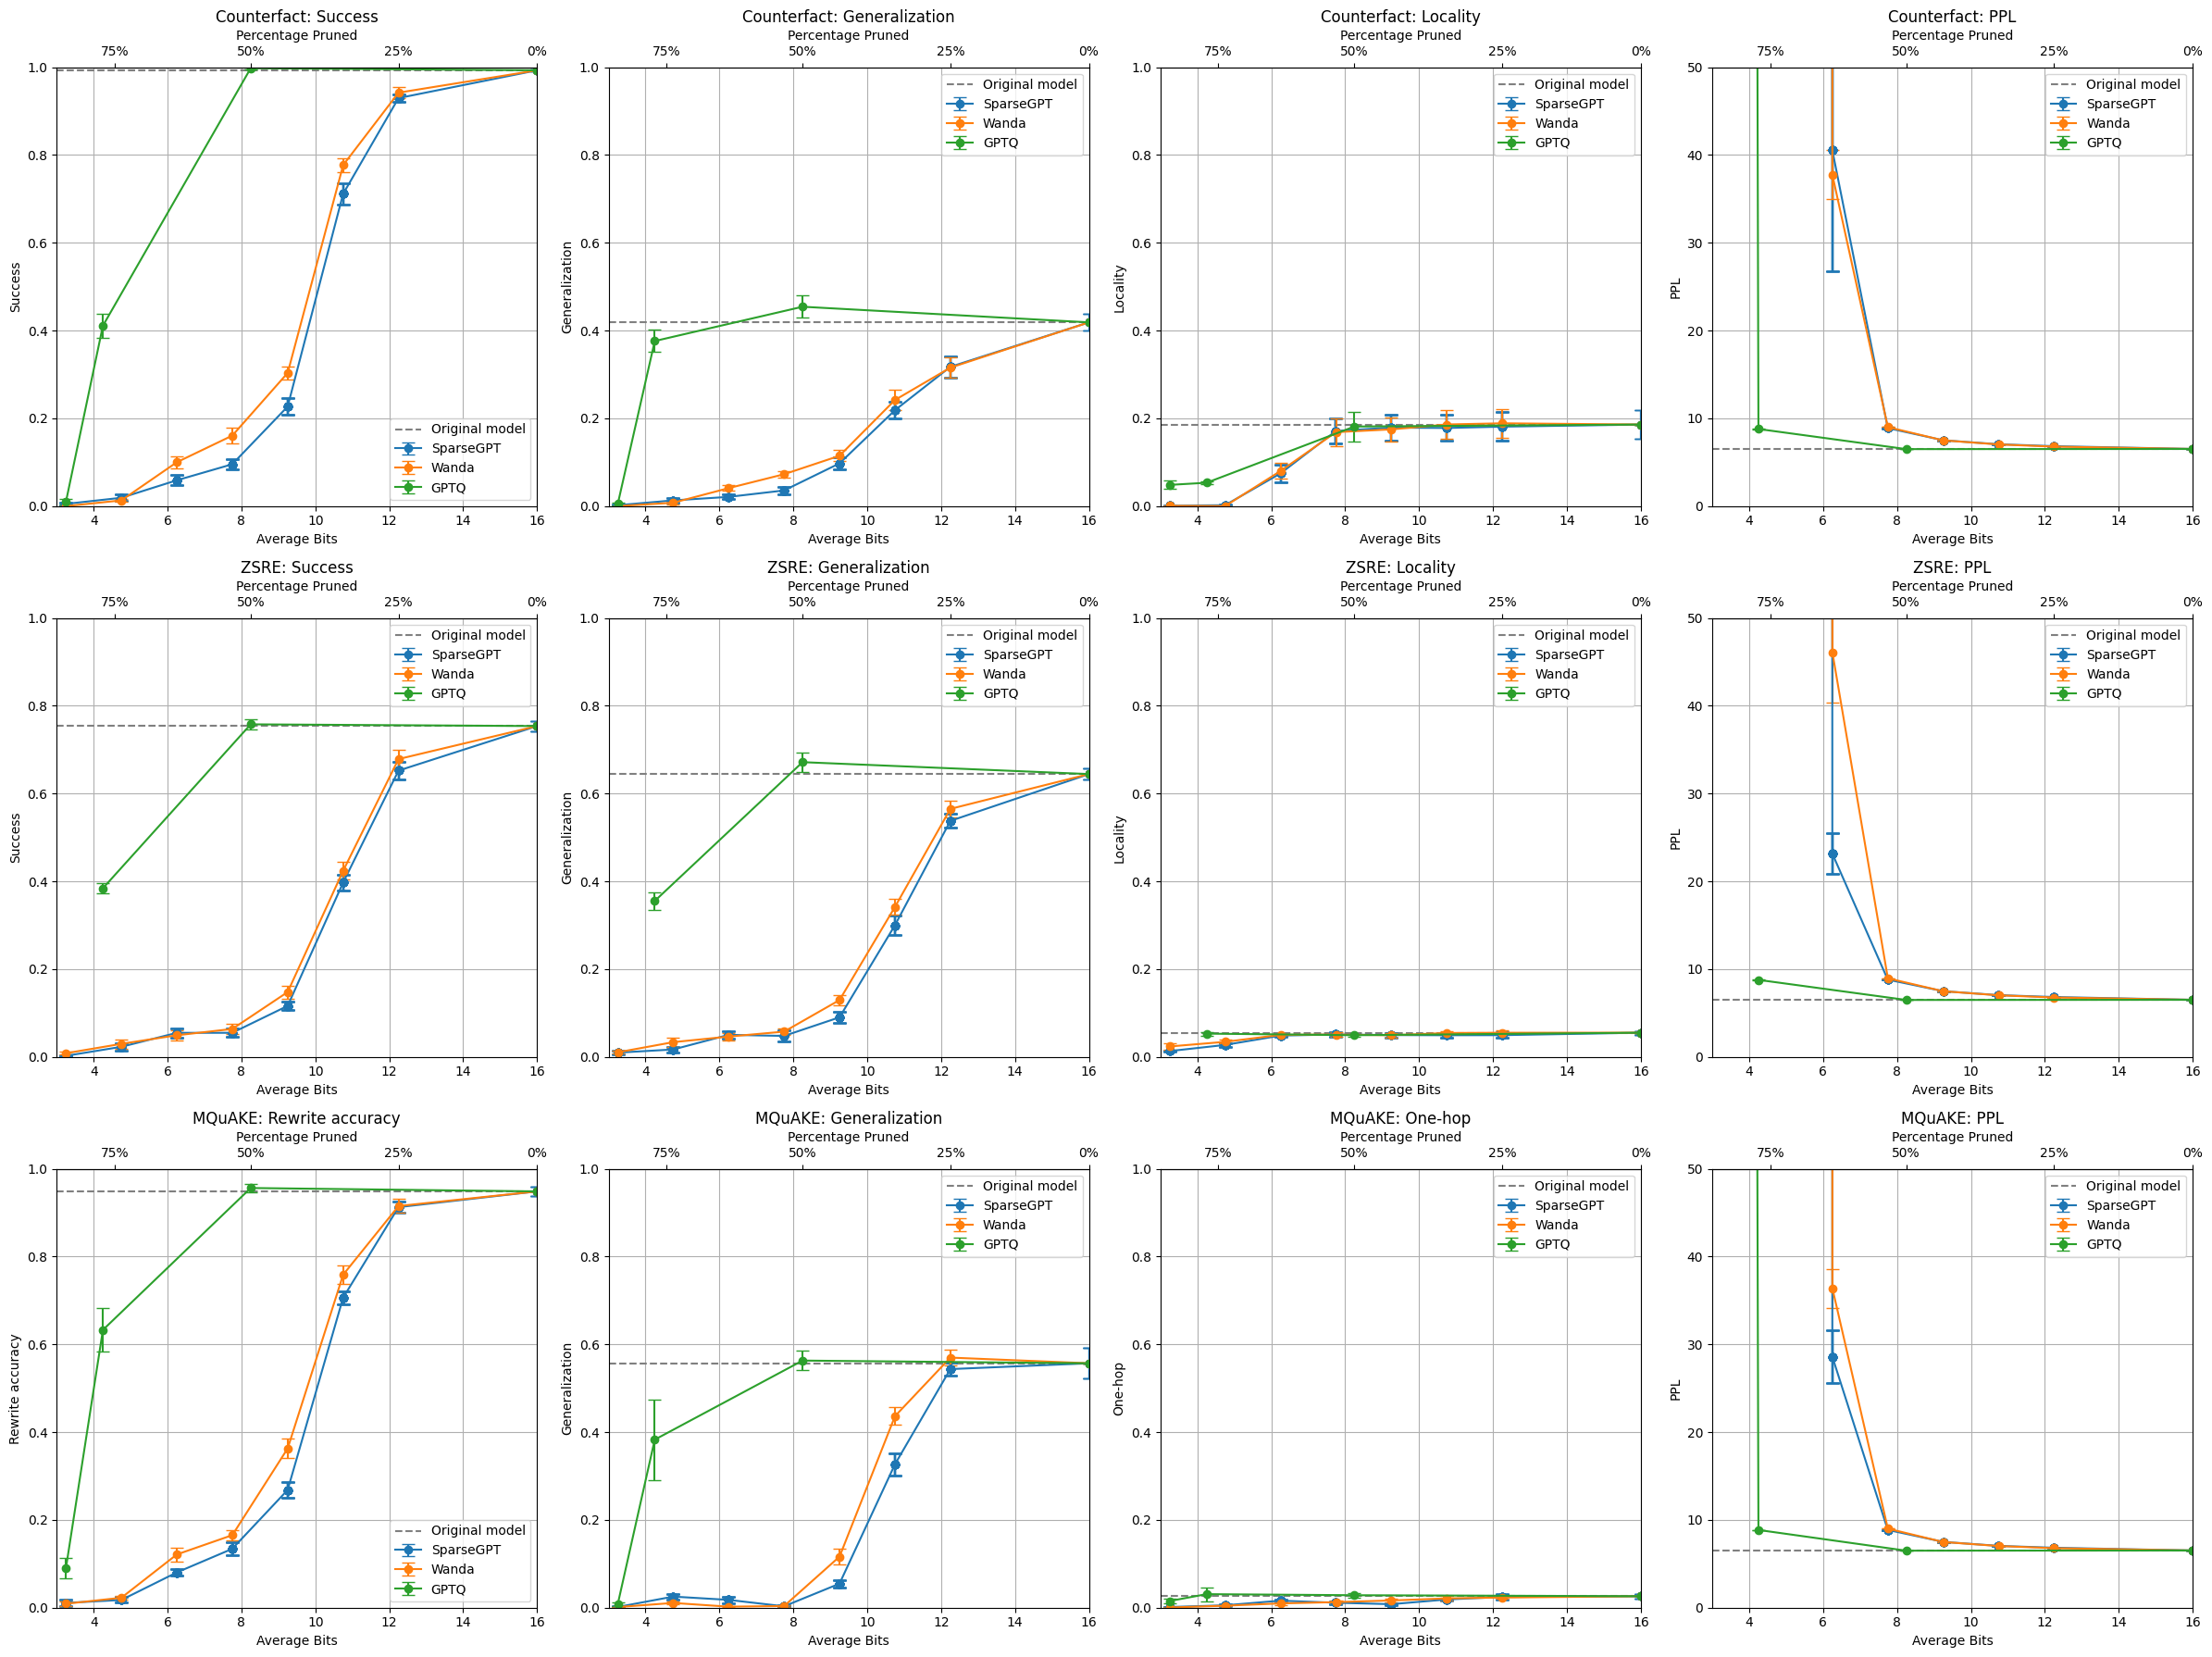

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(dataframes, titles, metrics):
    num_dfs = len(dataframes)
    
    # Create subplots with a row for each dataframe
    fig, axs = plt.subplots(num_dfs, len(metrics), figsize=(24, 6 * num_dfs))

    for df_index, df in enumerate(dataframes):
        baseline_values = {metric: df[df['sparsity_ratio'] == 0][metric].mean() for metric in metrics}
        
        for i, metric in enumerate(metrics):
            ax = axs[df_index, i] if num_dfs > 1 else axs[i]
            ylabel = 'Success' if 'Rewrite_accuracy' in metric else metric.split('_')[0]
            ax.axhline(y=baseline_values[metric], color='gray', linestyle='--', label='Original model')

            for method in df['method_name'].unique():
                method_data = df[df['method_name'] == method]
                new_data = pd.DataFrame({'Average bits': [16], metric: [baseline_values[metric]]})
                extended_method_data = pd.concat([method_data, new_data], ignore_index=True)
                extended_method_data_sorted = extended_method_data.sort_values(by='Average bits', ascending=False)

                ax.errorbar(extended_method_data_sorted['Average bits'], extended_method_data_sorted[metric], 
                            yerr=extended_method_data_sorted[metric.replace('mean', 'standard_error')].fillna(0), 
                            fmt='o-', label=method, capsize=5)

            ax.set_xlabel('Average Bits')
            ylabel = 'Success' if 'Rewrite accuracy' in metric else metric.split('_')[0]
            if titles[df_index] == 'MQuAKE':
                ylabel = 'One-hop' if 'Locality' in metric else metric.split('_')[0]
            ax.set_ylabel(ylabel)
            ax.set_title(f'{titles[df_index]}: {ylabel}')
            ax.legend()
            ax.grid(True)
            ax.set_xlim(3, 16)

            if i < 3:
                ax.set_ylim(0, 1)
            else:
                ax.set_ylim(0, 50)

            # Add a secondary x-axis for the percentage pruned
            secax = ax.secondary_xaxis('top')
            secax.set_xlabel('Percentage Pruned')
            secax.set_xticks([1, 4.57, 8.25, 12.25, 16])
            secax.set_xticklabels(['100%', '75%', '50%', '25%', '0%'])  # Adjust these values as needed

    plt.tight_layout()
    plt.show()


dfs = [compfirst_counterfact, compfirst_zsre, compfirst_mq]  #  DataFrames
metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']
titles = ['Counterfact', 'ZSRE', 'MQuAKE']
plot_metrics(dfs, titles, metrics)


### Metrics vs NLL

True
Success
False
Generalization
False
Locality
False
PPL


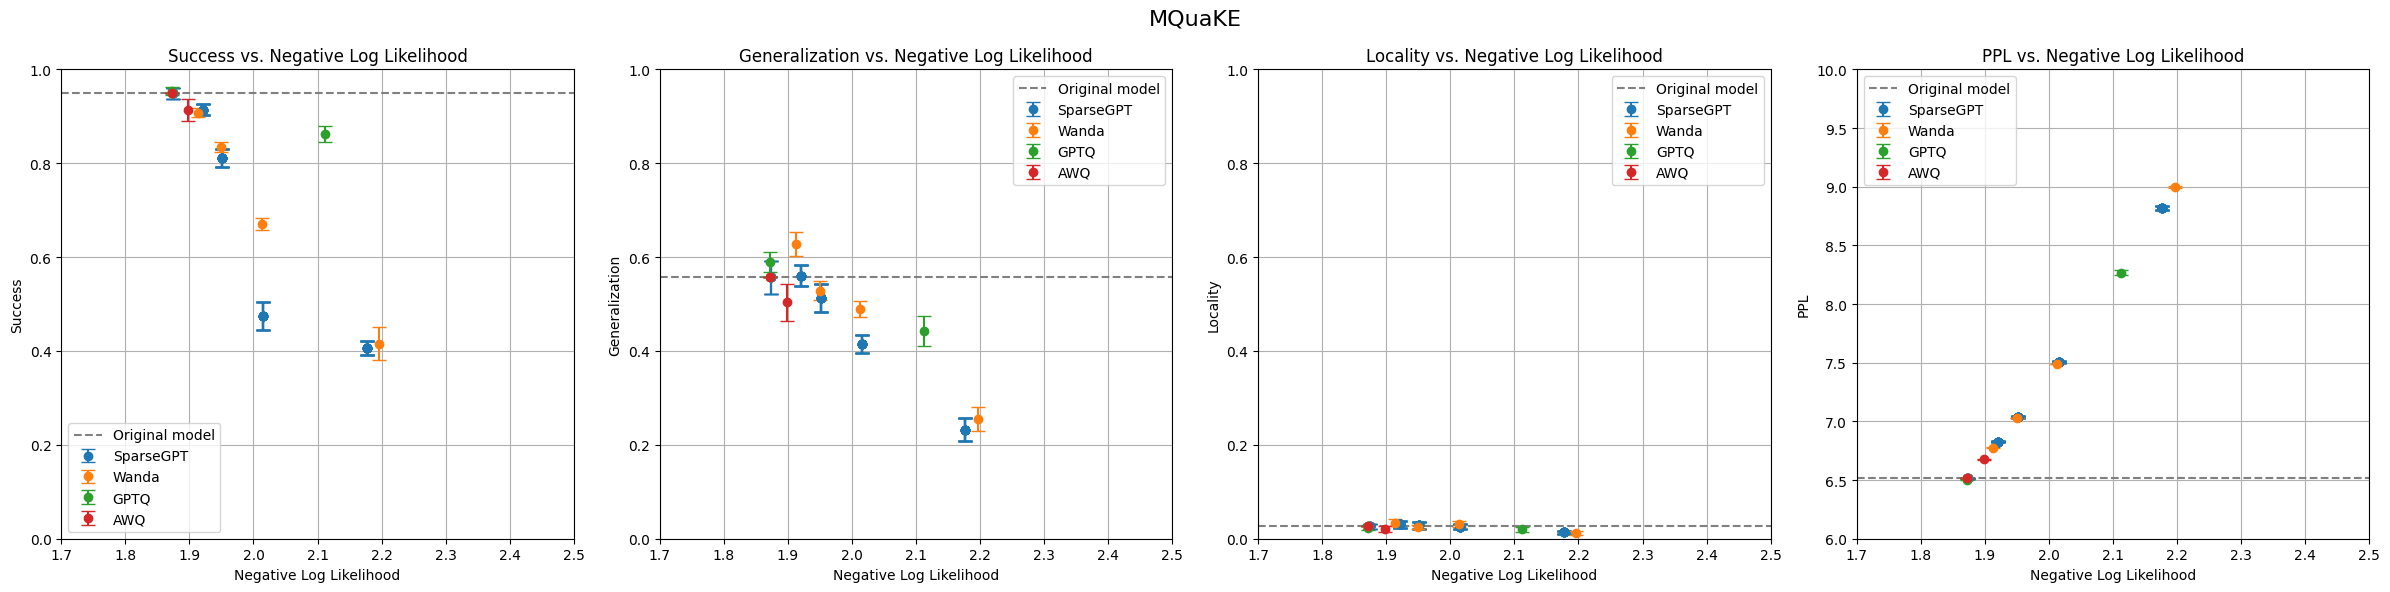

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your DataFrame here

df = edited_mq  # Use your DataFrame

metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Extract baseline values for each metric
baseline_values = {metric: df[df['sparsity_ratio'] == 0][metric].mean() for metric in metrics}

# Compute NLL from PPL
df['NLL'] = np.log(df['PPL_mean'])

for i, metric in enumerate(metrics):
    # Change the label 'Rewrite accuracy' to 'Success'
    # print(metric)
    print( 'Rewrite' in metric)
    ylabel = 'Success' if 'Rewrite' in metric else metric.split('_')[0]
    # print(ylabel)
    ylabel = 'One-hop' if 'Locality' in metric else metric.split('_')[0]

    # Plot baseline as a horizontal dotted line
    axs[i].axhline(y=baseline_values[metric], color='gray', linestyle='--', label='Original model')

    # Plot each method in the dataset, including a baseline point at the start
    for method in df['method_name'].unique():
        method_data = df[df['method_name'] == method]
        # Prepend the baseline data point
        baseline_data = pd.DataFrame({'NLL': [df['NLL'].min()], metric: [baseline_values[metric]]})
        method_data = pd.concat([baseline_data, method_data], ignore_index=True)
        axs[i].errorbar(method_data['NLL'], method_data[metric], 
                        yerr=method_data[metric.replace('mean', 'standard_error')].fillna(0), 
                        fmt='o', label=method, capsize=5)

    axs[i].set_xlabel('Negative Log Likelihood')
    ylabel = 'Success' if 'Rewrite' in metric else metric.split('_')[0]
    print(ylabel)
    axs[i].set_ylabel(ylabel)
    axs[i].set_title(f'{ylabel} vs. Negative Log Likelihood')
    axs[i].legend()
    axs[i].grid(True)

    # Adjust y-axis limits
    if i < 3:
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(6, 10)
    axs[i].set_xlim(1.7, 2.5)
fig.suptitle('MQuaKE', fontsize=16)
plt.tight_layout()
plt.show()


### NLL comparisons

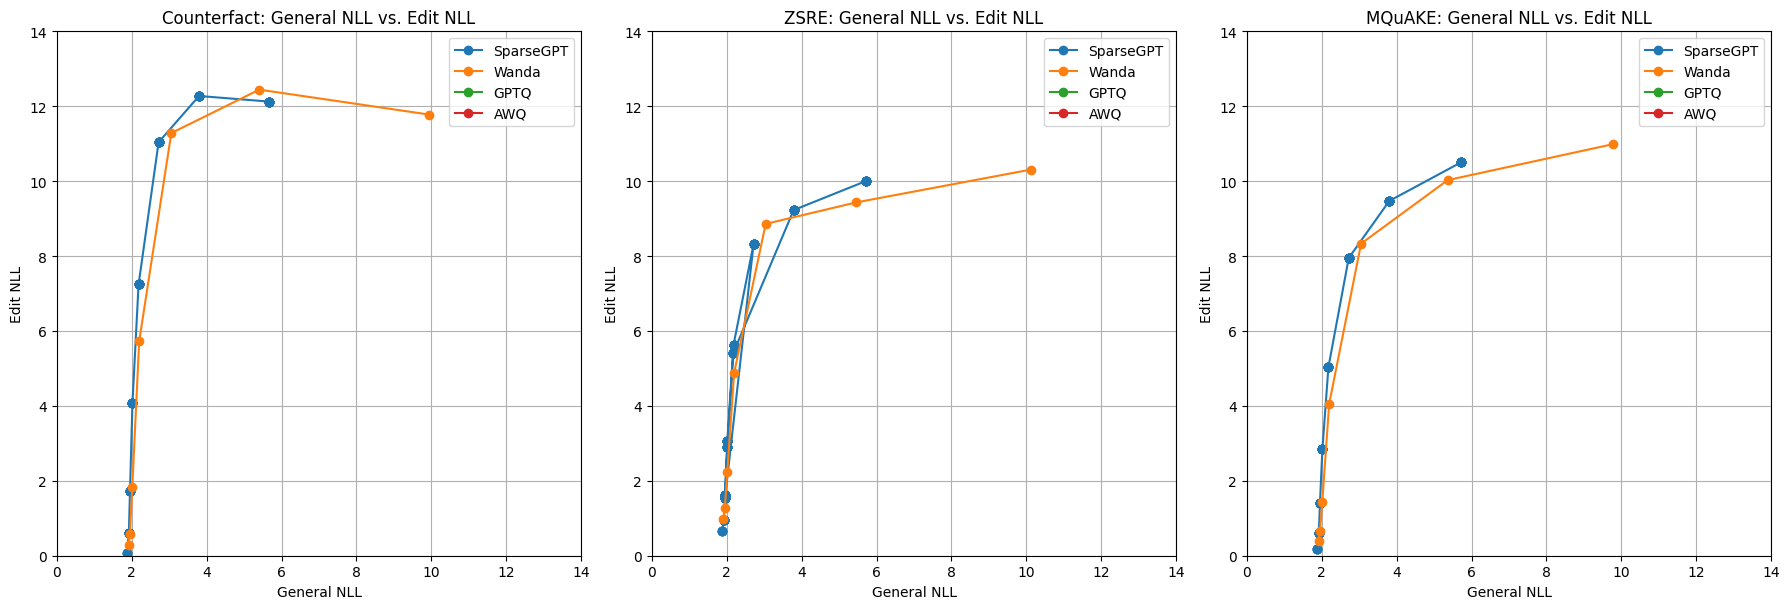

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_ppl_vs_edit_ppl_plots(dfs, titles):
    """
    Creates a row of subplots for PPL vs. edit PPL for each given DataFrame.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames containing the experiment data.
    titles (list of str): List of titles for each DataFrame.
    """
    num_dfs = len(dfs)
    fig, axs = plt.subplots(1, num_dfs, figsize=(6 * num_dfs, 6))

    for i, df in enumerate(dfs):
        ax = axs[i] if num_dfs > 1 else axs

        for method in df['method_name'].unique():
            method_data = df[(df['method_name'] == method) & (df['PPL edits_mean'] < np.inf)]
            ax.errorbar(np.log(method_data['PPL_mean']), np.log(method_data['PPL edits_mean']), 
                        # Uncomment the following line if standard error is available
                        # xerr=np.log(method_data['PPL_standard_error']), yerr=np.log(method_data['PPL_standard_error']),
                        fmt='o-', label=method, capsize=5)

        ax.set_xlabel('General NLL')
        ax.set_ylabel('Edit NLL')
        ax.set_title(f'{titles[i]}: General NLL vs. Edit NLL')
        ax.legend()
        ax.grid(True)

        ax.axis('square')
        ax.set_ylim(0, 14)
        ax.set_xlim(0, 14)

    plt.tight_layout()
    plt.show()

# Example usage
dfs = [edited_counterfact, edited_zsre, edited_mq]  # Replace with your list of dataframes
titles = ["Counterfact", "ZSRE", "MQuAKE"]  # Replace with your titles
create_ppl_vs_edit_ppl_plots(dfs, titles)
